In [1]:
import os, sys, tarfile

import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread


# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
#from random import randint
#import pickle





In [2]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2023-11-30 07:05:01--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  40.4MB/s    in 6.0s    

2023-11-30 07:05:07 (36.3 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [3]:
def extractzipfolder():
  tar = tarfile.open("/content/flower_photos.tgz")
  tar.extractall()
  tar.close()

In [4]:
def unique_filename(file):
    duplicate_nr = 0
    base, extension = os.path.splitext(file)
    while os.path.exists(file):
        duplicate_nr += 1
        file = f'{base}({duplicate_nr}){extension}'
    return file

In [5]:
existsFile = []
flowers_list = []
def move_file(source, destination):
  files = os.listdir(source)
  for file in files:
    isMove=False
    fileName = file
    if(file.endswith(".jpg")):
      basefolder = os.path.basename(os.path.normpath(source))
      if(os.path.exists(os.path.join(destination,file))):
        actualsource_file_path = os.path.join(source, file)
        dir_file_path = unique_filename(actualsource_file_path)
        fileName = dir_file_path
        os.rename(os.path.join(destination,file), dir_file_path)
        shutil.move(dir_file_path, destination)
        os.unlink(actualsource_file_path)
        isMove = True
      else:
          shutil.move(os.path.join(source,file), destination)
          isMove= True
    else:
      if(file.endswith(".txt") == False):
        move_file(os.path.join(rootsource,file), destination)
      #file_name = os.path.join(source, file)
    if(isMove):
      flowers_list.append(
        {
            'Category': basefolder,
            'file_name': fileName
        }
      )
  return flowers_list

In [6]:
def delete_empty_folder(folder_path):
  for entry in os.scandir(folder_path):
    if os.path.isdir(entry.path) and not os.listdir(entry.path):
      shutil.rmtree(entry.path)

In [7]:
import shutil
import os

extractzipfolder()
# Define the source and destination path
rootsource = "/content/flower_photos"
destination = "/content/flower_photos"
list_flower = move_file(rootsource,destination)
delete_empty_folder("/content/flower_photos");


In [32]:
path = r"/content/flower_photos"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the flowers list
          if(len(flowers) < 501):
            flowers.append(file.name)
          else:
            break

In [33]:
# view the first 5 flower entries
print(flowers)

['921138131_9e1393eb2b_m.jpg', '4164845062_1fd9b3f3b4.jpg', '5043409092_5b12cc985a_m.jpg', '8929213942_5544191250_n.jpg', '2443921986_d4582c123a.jpg', '4745985619_249078cafa_n.jpg', '13910028149_6c9d5485ef.jpg', '11405573_24a8a838cc_n.jpg', '13807932364_673b7f1c1c_n.jpg', '497305666_b5d4348826_n.jpg', '5994586159_1dd99d66b4_n.jpg', '7055500907_dcf2bb50e0.jpg', '459042023_6273adc312_n.jpg', '4573886524_5161482ca7_n.jpg', '2927020075_54c9186797_n.jpg', '2497301920_91490c42c0.jpg', '16485607329_e66d5960bc_m.jpg', '7166598930_18d8686ace_n.jpg', '5543457754_89c44c88de_n.jpg', '2733109082_1351f6738a_n.jpg', '13539827514_79b60b6c22_n.jpg', '3326037909_b5ae370722_n.jpg', '3764116502_f394428ee0_n.jpg', '2569516382_9fd7097b9b.jpg', '16772483324_09f24813a1_n.jpg', '14219214466_3ca6104eae_m.jpg', '9167147034_0a66ee3616_n.jpg', '7267547016_c8903920bf.jpg', '16449467833_d82aac5749_m.jpg', '4279990882_031482f8b6_n.jpg', '5339004958_a0a6f385fd_m.jpg', '3463313493_9497aa47e5_n.jpg', '10919961_0af657c4e

In [34]:
def load_images(path):
    flower_pixel = imread("/content/flower_photos/"+path)
    return flower_pixel

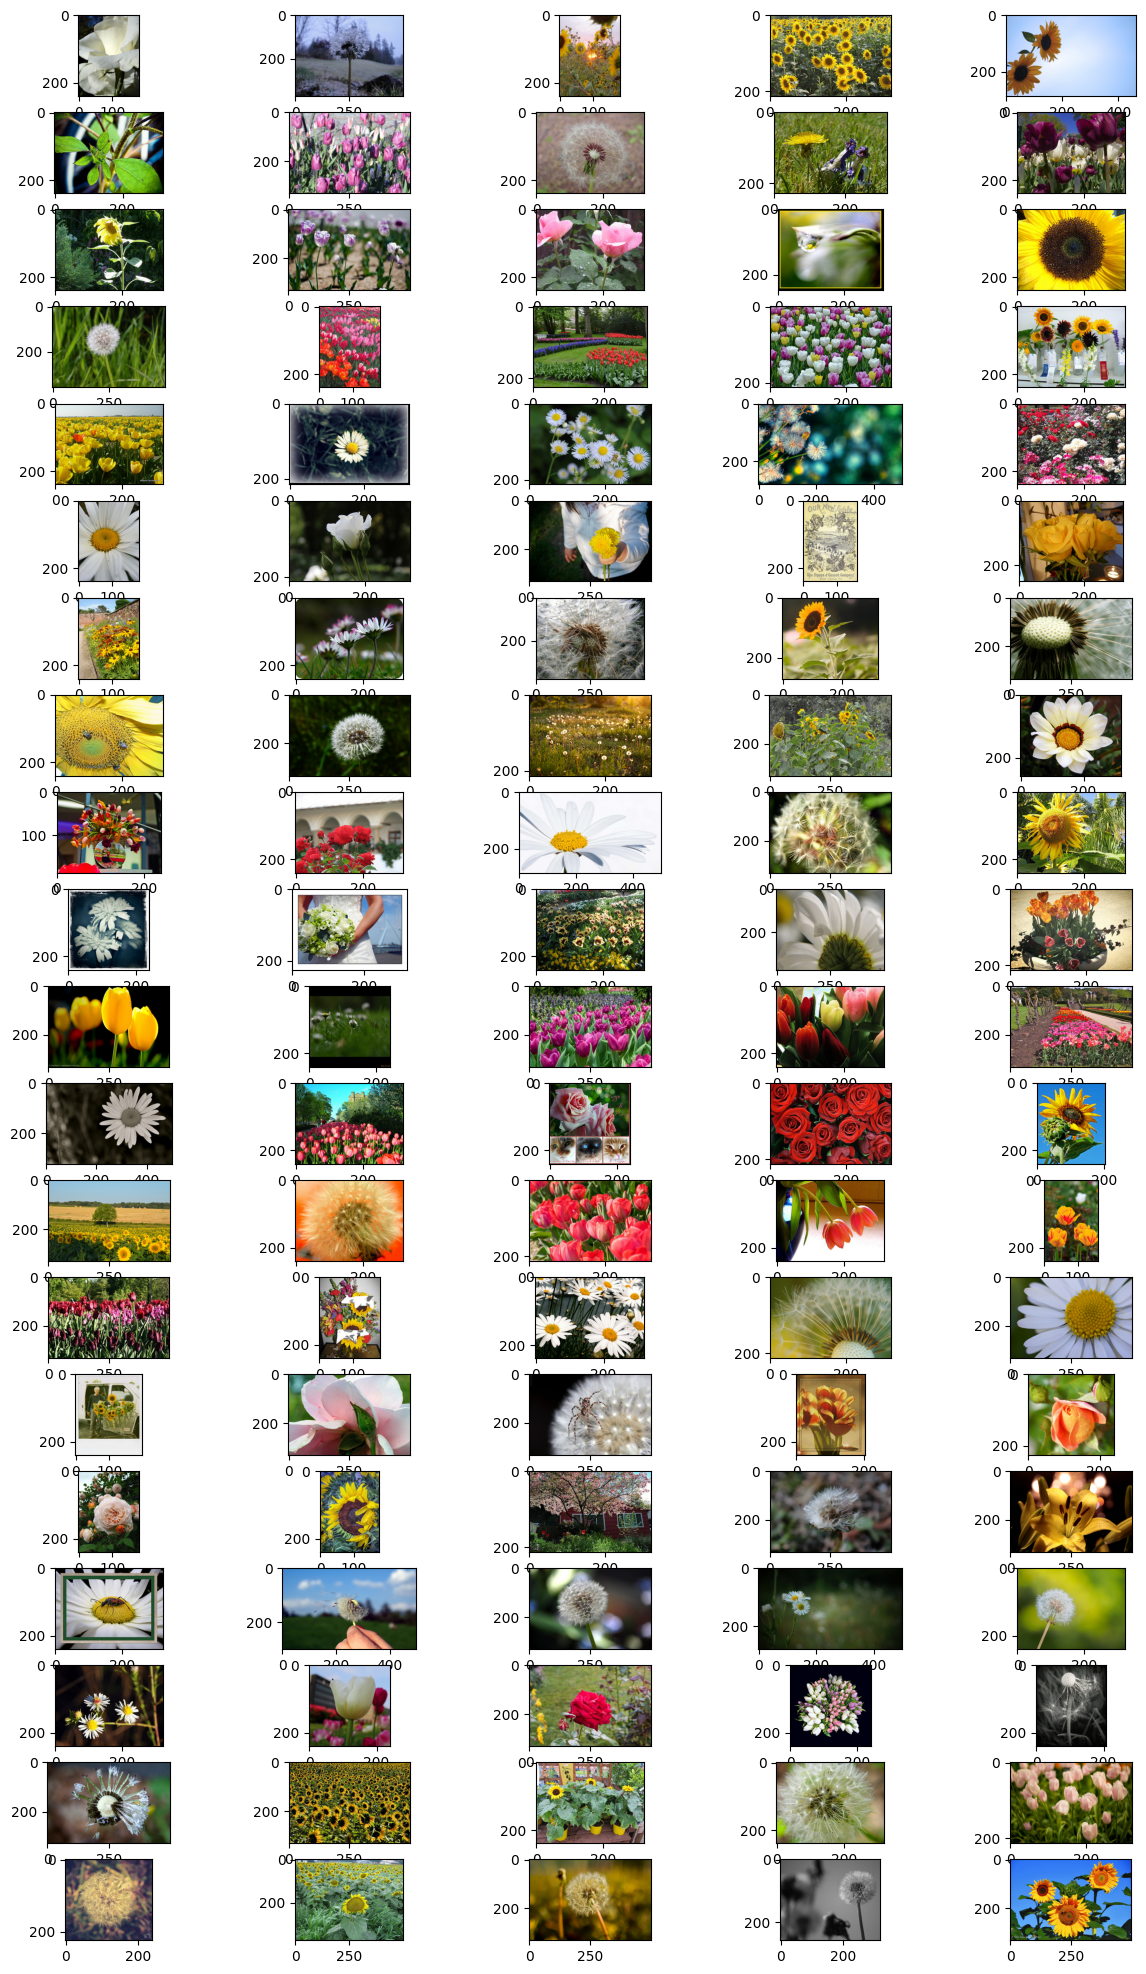

In [36]:
plt.figure(figsize = (15, 25))
actual_image_shapes = []
for i in range(len(flowers[0:100])):
  pixels = load_images(flowers[i])
  #reshaped_pixels = pixels.reshape(pixels.shape[0] * pixels.shape[1], pixels.shape[2])
  plt.subplot(20, 5, i + 1)
  plt.imshow(pixels);
  #actual_image_shapes.append({"name" : flowers[i], "shape" : pixels.shape, "reshape:" : reshaped_pixels.shape})
  actual_image_shapes.append({"name" : flowers[i], "shape" : pixels.shape})
plt.show()
df_image_shapes = pd.DataFrame(actual_image_shapes)

In [37]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [38]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [39]:
data = {}
p = r"flower_features.pkl"

# lop through each image in the dataset
for flower in flowers:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(flower,model)
        data[flower] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)




1/1 [==============================] - 0s 24ms/step


In [40]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

# get the unique labels (from the flower_labels.csv)
unique_labels = [0,1,2]

In [42]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 100


In [43]:
# cluster feature vectors
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=22)

In [44]:
kmeans.labels_

array([2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 0,
       0, 1, 2, 0, 0, 2, 2, 2, 2, 0, 1, 0, 1, 1, 1, 2, 2, 0, 2, 2, 0, 1,
       1, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2,
       2, 0, 1, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 1, 1, 1, 0, 2, 2,
       0, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 2, 0, 2, 0, 2, 0,
       1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 0, 0,
       0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2,
       2, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2,
       1, 1, 0, 1, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 1, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2,
       0, 1, 2, 1, 2, 0, 2, 0, 2, 2, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 2, 0,
       1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 0, 0, 2, 0, 2, 2, 2, 0, 1, 2, 2, 0,
       2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2,
       0, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 2, 0, 2, 1,

In [45]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [46]:
# function that lets you view a cluster (based on identifier)
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [ ]:
# this is just incase you want to see which value for k might be the best
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)

    sse.append(km.inertia_)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

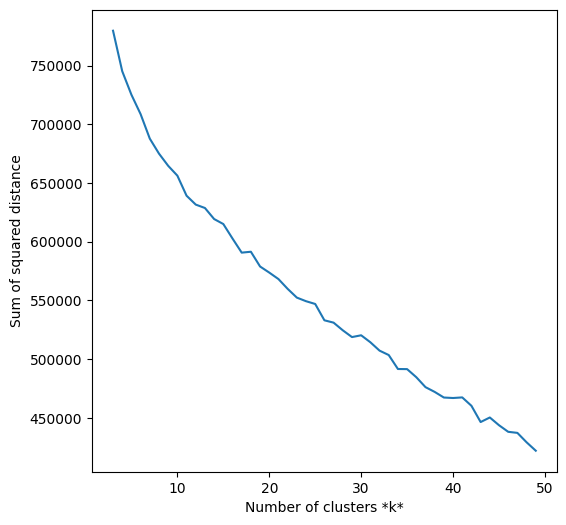

In [ ]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Cluster: 0


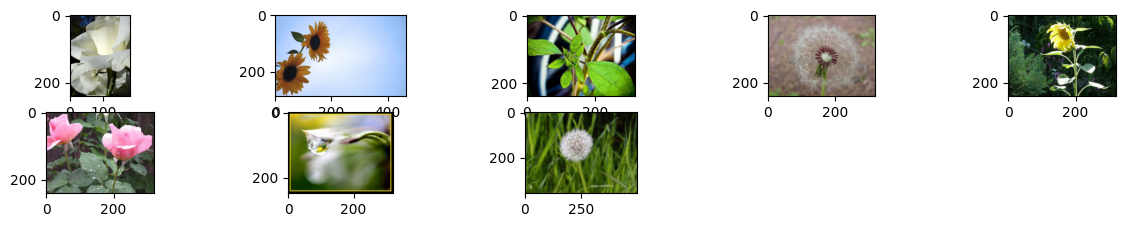

Cluster: 1


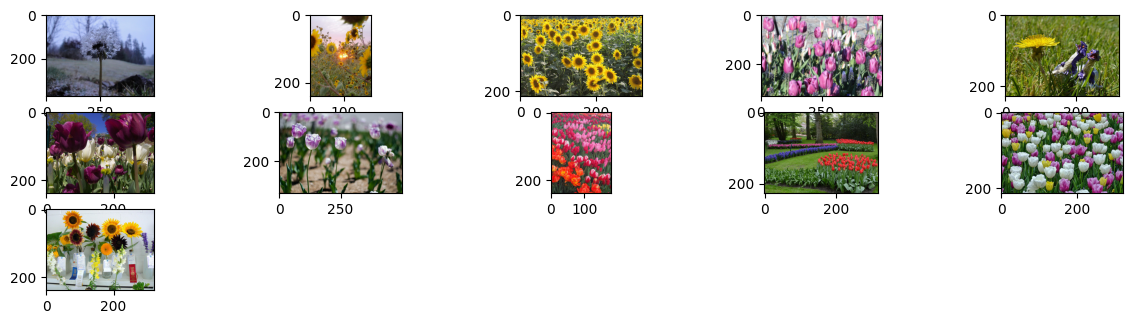

Cluster: 2


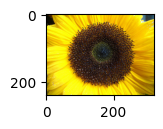

In [23]:

actual_image_shapes = []
for i in range(len(groups)):
  print("Cluster:", i)
  plt.figure(figsize = (15, 25))
  for j in range(len(groups[i])):
    pixels = load_images(groups[i][j])
    plt.subplot(20, 5, j + 1)
    plt.imshow(pixels);
  plt.show()

Clipping cluster size from 274 to 30


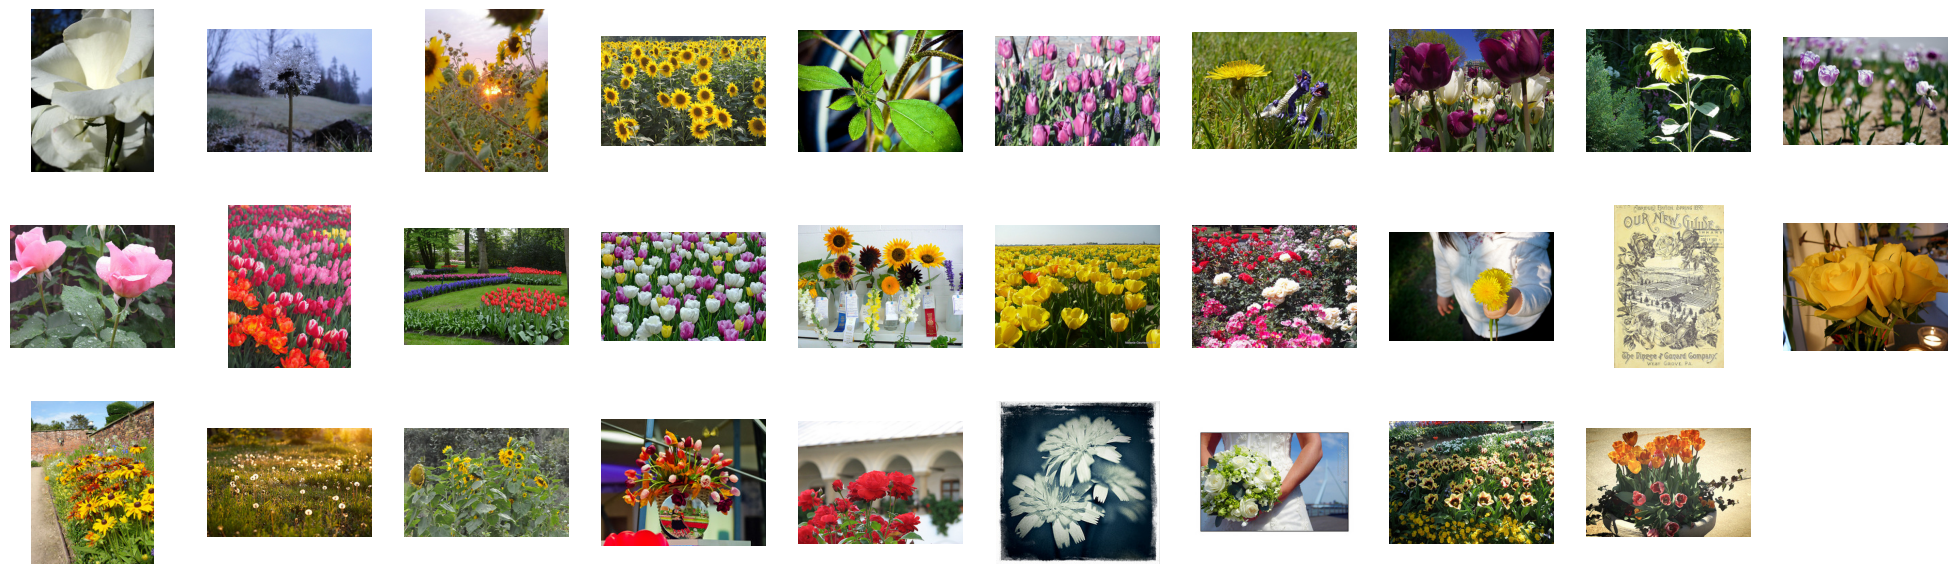

In [49]:
view_cluster(2)